# Downsample dataset

The downsampling follows these criteria:
1. The papers are from 2010 to present.
2. The papers are relevant to Drosophila neurobiology (likely to contain descriptions of neuronal cell types)

In [1]:
import sys
sys.path.append("../python/extraction")

from utils import Paper
import pandas as pd
import matplotlib.pyplot as plt
from langchain_openai import ChatOpenAI

Text(0.5, 1.0, 'Publications by Year')

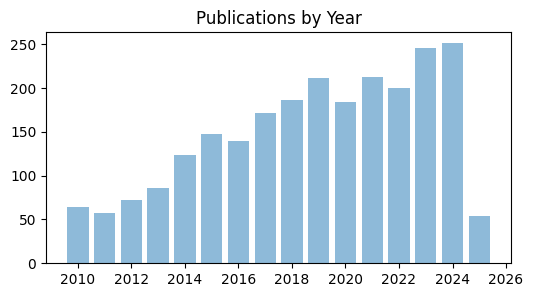

In [2]:
df = pd.read_csv("../assets/pubmed_search_results.csv")
df = df[df["Publication Year"] >= 2010]
df = df.dropna(subset=["full_text_path"])

# Count the number of papers per year
year_counts = df["Publication Year"].value_counts().sort_index()
plt.figure(figsize=(6, 3))
plt.bar(year_counts.index, year_counts.values, alpha=0.5, label='Total Publications')
plt.title("Publications by Year")

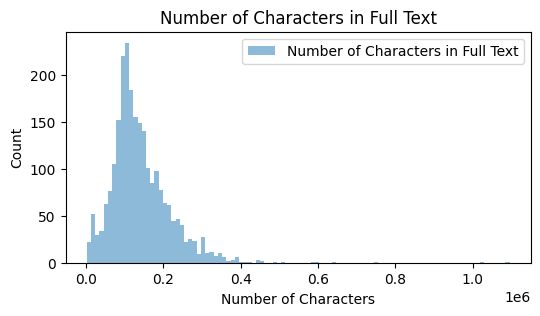

In [3]:
# Number of characters in the full text (json file)
df["num_chars"] = df["full_text_path"].apply(lambda x: len(open(f"../{x}").read()))

# Plot the number of characters in the full text
plt.figure(figsize=(6, 3))
plt.hist(df["num_chars"], bins=100, alpha=0.5, label='Number of Characters in Full Text')
plt.title("Number of Characters in Full Text")
plt.xlabel("Number of Characters")
plt.ylabel("Count")
plt.legend()
plt.show()

In [4]:
# Filter out 5% of the papers with the least characters
df = df.sort_values(by="num_chars", ascending=True)
sub_df = df.iloc[:int(len(df) * 0.95)]
print(f"Number of papers after filtering: {len(sub_df)}")

Number of papers after filtering: 2285


In [5]:
# Downsample 100 papers randomly
sub_df = sub_df.sample(100, random_state=42)

In [6]:
# Convert the pmids to papers
papers = [Paper.from_pmid(pmid) for pmid in sub_df["PMID"]]

In [7]:
# Check if the paper contains title and abstract
for paper in papers:
    if paper.title is None or paper.abstract is None:
        print(f"Paper {paper.pmid} has no title or abstract")
        print(paper.to_str())
        print('-' * 100)

Paper 24107996 has no title or abstract
Title: Feature detection and orientation tuning in the Drosophila central complex
Abstract: None
INTRO 1: Many animals, including insects, are known to use visual landmarks to orient in their environment. In Drosophila melanogaster, behavioral genetics studies have identified a higher brain structure called the central complex as being required for the fly’s innate responses to vertical visual features and its short- and long-term memory for visual patterns. But whether and how neurons of the fly central complex represent visual features is unknown. We used two-photon calcium imaging in head-fixed walking and flying flies to probe visuomotor responses of ring neurons—a class of central complex neurons that have been implicated in landmark-driven spatial memory in walking flies and memory for visual patterns in tethered flying flies. We found that dendrites of ring neurons are visually responsive and arranged retinotopically. Ring neuron receptive

In [8]:
# Check if the paper is relevant by llm
llm = ChatOpenAI(model="gpt-4o", temperature=0)
system_prompt = """
You are a neurobiologist.
You are given a paper, but only the title, abstract, introduction, and results sections.
You need to determine if the paper describes any neuronal cell types of Drosophila.
If you are confident that it does, respond with "Yes". Otherwise, respond with "No".
Then, gives an explanation of your reasoning on next line.
"""

# Check if the paper is relevant by llm, using batch processing
messages = []
for paper in papers:
    messages.append([("system", system_prompt), ("user", paper.to_str())])

# Get the responses
responses = llm.batch(
    messages, config={"max_concurrency": 5}
)  # Limit concurrent API calls

In [9]:
results = [response.content.lower().startswith("yes") for response in responses]

# Count the number of relevant papers
relevant_count = sum(results)
print(f"Number of relevant papers: {relevant_count}/{len(papers)}")

Number of relevant papers: 88/100


In [10]:
sub_df = sub_df[results]

In [11]:
# Save the downsampled papers using pmids
sub_df["PMID"].to_csv("../assets/downsampled_pmids.txt", index=False, header=False)


In [6]:
import random

# Downsample to 25 papers
with open("../assets/downsampled_pmids.txt") as f:
    pmids = f.readlines()
    pmids = [x.strip() for x in pmids]

# Randomly sample 25 PMIDs without replacement
random.seed(42)
sampled_pmids = random.sample(pmids, k=25)
for pmid in sampled_pmids:
    print(pmid)


33079061
29943729
39038490
38014328
28489002
33667373
38712267
32433963
34230464
24684937
37163061
29255026
33770490
39548088
38948859
24055154
35353036
22794255
35833625
32916090
36352224
29467404
31488722
38979352
32894223
